# Data Preprocessing

In [46]:
import os
import statistics
import torch

In [2]:
fasta = open('trna.fa','r').read().splitlines()

In [3]:
len(fasta)

84076

In [96]:
fasta[:10]

trna = []

for i,s in enumerate(fasta[:100]):
    if ((2*i) + 1) %3 == 0:
        m = fasta[i] + fasta[i+1]
        trna.append(m)


# for i,s in enumerate(fasta[:200]):
#     if (i+1)%3 ==0:
#         trna.append(fasta[i])

    

In [97]:
trna

['GGGGTTATAACTCAGTGGCAGAGTGGAAGATTGCAGATCTTCTGGtCCCGTGTTCGATCCACGGTGGCCCCT',
 'GGGGATATGGTGTAGGGGTATCACGTTTGCTTTGCATGCAAAAGGcCAGGGGTTCAAATCCCTTTGTCTCCA',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGtACTGGGATCGACGCCCAGCTTCTCCA',
 'GGGGTAGTAGCTCAAATGGTAGAGCGCTCGCTTCGCATGCGAGAGGcACCGTGATCGATACACGGCTATTCCA',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGcACTGGGATCGACGCCCAGCTTCTCCA',
 'GGGGTTATAACTCAGTGGCAGAGTGGAAGATTGCAGATCTTCTGGtCCCGTGTTCGATCCACGGTGGCCCCT',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGtACTGGGATCGACGCCCAGCTTCTCCA',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGtACTGGGATCGACGCCCAGCTTCTCCA',
 'GGGGATATGGTGTAGGGGTATCACGTTTGCTTTGCATGCAAAAGGcCAGGGGTTCAAATCCCTTTGTCTCCA',
 'GGGGATATGGTGTAGGGGTATCACGTTTGCTTTGCATGCAAAAGGcCAGGGGTTCAAATCCCTTTGTCTCCA',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGtACTGGGATCGACGCCCAGCTTCTCCA',
 'GGGGTTATTCCTTAAATGGTAGAGGGCTCGTTTTGCATACGAGTAgTCCGAGTTCGAGTCTCGGTAACTCCA',
 'GACCAACTAGCATAATTGGTAATGCGATAGATTGCAAATCTTCCAGaTAAGTGTTCAAGTCACTTGTT

In [98]:
type(trna)

list

In [99]:
maxi = max(len(w) for w in trna)

In [100]:
maxi

106

In [101]:
for i,s in enumerate(trna):
    pad = maxi- len(s)
    s += 'N' * pad
    trna[i] = s

In [102]:
trna

['GGGGTTATAACTCAGTGGCAGAGTGGAAGATTGCAGATCTTCTGGtCCCGTGTTCGATCCACGGTGGCCCCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGATATGGTGTAGGGGTATCACGTTTGCTTTGCATGCAAAAGGcCAGGGGTTCAAATCCCTTTGTCTCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGtACTGGGATCGACGCCCAGCTTCTCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGTAGTAGCTCAAATGGTAGAGCGCTCGCTTCGCATGCGAGAGGcACCGTGATCGATACACGGCTATTCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGcACTGGGATCGACGCCCAGCTTCTCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGTTATAACTCAGTGGCAGAGTGGAAGATTGCAGATCTTCTGGtCCCGTGTTCGATCCACGGTGGCCCCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGtACTGGGATCGACGCCCAGCTTCTCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGATGTAGCTCAAATGGTAGAGCGCTCGCTTAGCATGCGAGAGGtACTGGGATCGACGCCCAGCTTCTCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 'GGGGATATGGTGTAGGGGTATCACGTTTGCTTTGCATGCAAAAGGcCAGGGGTTCAAATCCCTTTGTCTCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN',
 

In [103]:
N = torch.zeros((maxi, 5),  dtype = torch.int32)

In [104]:
bases = ['A','T','C','G','N']

In [105]:
stoi = {'A': 0, 'T': 1, 'C':2, 'G':3, 'N':4}
itos = {i:s for s,i in stoi.items()}

In [106]:
trna = [t.upper() for t in trna]

for seq in trna:
    for i, b in enumerate(seq):
        ix2 = i # the row number
        ix1 = stoi[b]
        N[ix2][ix1] += 1

In [107]:
#N

tensor([[ 0,  0,  0, 33,  0],
        [16,  1,  0, 16,  0],
        [ 2, 15,  2, 14,  0],
        [ 0,  0, 19, 14,  0],
        [25,  6,  1,  1,  0],
        [ 3, 28,  2,  0,  0],
        [24,  2,  1,  6,  0],
        [ 0, 33,  0,  0,  0],
        [28,  1,  0,  4,  0],
        [ 4,  0,  1, 28,  0],
        [ 0,  4, 29,  0,  0],
        [ 1, 28,  1,  3,  0],
        [ 1,  7, 25,  0,  0],
        [33,  0,  0,  0,  0],
        [ 8,  0,  0, 25,  0],
        [ 7, 22,  0,  4,  0],
        [ 0,  8,  0, 25,  0],
        [ 0,  0,  0, 33,  0],
        [ 0, 21,  4,  8,  0],
        [ 9, 24,  0,  0,  0],
        [24,  5,  0,  4,  0],
        [ 6,  1,  3, 23,  0],
        [27,  1,  0,  5,  0],
        [ 0,  4,  5, 24,  0],
        [ 0,  0, 23, 10,  0],
        [ 1, 20,  0, 12,  0],
        [ 6, 20,  7,  0,  0],
        [ 4, 12, 16,  1,  0],
        [ 1,  0, 23,  9,  0],
        [ 4, 15,  5,  9,  0],
        [17, 10,  6,  0,  0],
        [ 0, 18,  0, 15,  0],
        [ 0, 28,  1,  4,  0],
        [ 

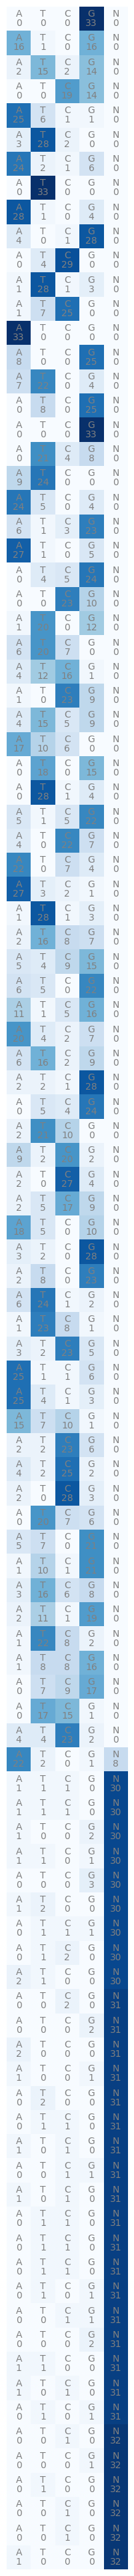

In [113]:
plt.figure(figsize = (50,50))
plt.imshow(N, cmap = 'Reds')
for i in range(5):
    for j in range(maxi):
        plt.text(i, j, itos[i], ha = 'center', va = 'bottom', color = 'gray') #horizontal and vertical alognments
        plt.text(i, j, N[j, i].item(), ha = 'center', va = 'top', color = 'gray') # the count at the bottom
plt.axis('off');



In [111]:
P = (N+ 1).float() #N are the counts from the gra
P /= P.sum(1, keepdims = True) 

In [116]:
P

tensor([[0.0263, 0.0263, 0.0263, 0.8947, 0.0263],
        [0.4474, 0.0526, 0.0263, 0.4474, 0.0263],
        [0.0789, 0.4211, 0.0789, 0.3947, 0.0263],
        [0.0263, 0.0263, 0.5263, 0.3947, 0.0263],
        [0.6842, 0.1842, 0.0526, 0.0526, 0.0263],
        [0.1053, 0.7632, 0.0789, 0.0263, 0.0263],
        [0.6579, 0.0789, 0.0526, 0.1842, 0.0263],
        [0.0263, 0.8947, 0.0263, 0.0263, 0.0263],
        [0.7632, 0.0526, 0.0263, 0.1316, 0.0263],
        [0.1316, 0.0263, 0.0526, 0.7632, 0.0263],
        [0.0263, 0.1316, 0.7895, 0.0263, 0.0263],
        [0.0526, 0.7632, 0.0526, 0.1053, 0.0263],
        [0.0526, 0.2105, 0.6842, 0.0263, 0.0263],
        [0.8947, 0.0263, 0.0263, 0.0263, 0.0263],
        [0.2368, 0.0263, 0.0263, 0.6842, 0.0263],
        [0.2105, 0.6053, 0.0263, 0.1316, 0.0263],
        [0.0263, 0.2368, 0.0263, 0.6842, 0.0263],
        [0.0263, 0.0263, 0.0263, 0.8947, 0.0263],
        [0.0263, 0.5789, 0.1316, 0.2368, 0.0263],
        [0.2632, 0.6579, 0.0263, 0.0263, 0.0263],
